In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/X.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy
sign-language-digits-dataset



(-0.5, 63.5, 63.5, -0.5)

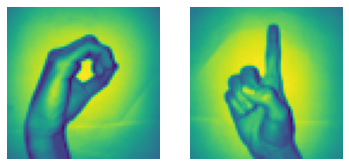

In [2]:
# load data set
x_l = np.load('/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy')
Y_l = np.load('/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy')
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis('off')

In [3]:
# Join a sequence of arrays along an row axis.
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) # from 0 to 204 is zero sign and from 205 to 410 is one sign 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


In [4]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [5]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [6]:
x_train = X_train_flatten.T
x_test = X_test_flatten.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 348)
x test:  (4096, 62)
y train:  (1, 348)
y test:  (1, 62)


In [7]:
# intialize parameters and layer sizes
def initialize_parameters_and_layer_sizes_NN(x_train, y_train):
    parameters = {"weight1": np.random.randn(10,x_train.shape[0]) * 0.1,
                  "bias1": np.zeros((10,1)),
                  "weight2": np.random.randn(y_train.shape[0],10) * 0.1,
                  "bias2": np.zeros((y_train.shape[0],1))}
    return parameters

In [8]:
# define sigmoid
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [9]:
def forward_propagation_NN(x_train, parameters):

    Z1 = np.dot(parameters["weight1"],x_train) +parameters["bias1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(parameters["weight2"],A1) + parameters["bias2"]
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [10]:
# Compute cost
def compute_cost_NN(A2, Y, parameters):
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)/Y.shape[1]
    return cost

In [11]:
# Backward Propagation
def backward_propagation_NN(parameters, cache, X, Y):

    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]
    dZ1 = np.dot(parameters["weight2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]
    grads = {"dweight1": dW1,
             "dbias1": db1,
             "dweight2": dW2,
             "dbias2": db2}
    return grads

In [12]:
# update parameters
def update_parameters_NN(parameters, grads, learning_rate = 0.01):
    parameters = {"weight1": parameters["weight1"]-learning_rate*grads["dweight1"],
                  "bias1": parameters["bias1"]-learning_rate*grads["dbias1"],
                  "weight2": parameters["weight2"]-learning_rate*grads["dweight2"],
                  "bias2": parameters["bias2"]-learning_rate*grads["dbias2"]}
    
    return parameters

In [13]:
# prediction
def predict_NN(parameters,x_test):
    # x_test is a input for forward propagation
    A2, cache = forward_propagation_NN(x_test,parameters)
    Y_prediction = np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1),
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0),
    for i in range(A2.shape[1]):
        if A2[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

Cost after iteration 0: 0.305659
Cost after iteration 500: 0.129196
Cost after iteration 1000: 0.058183
Cost after iteration 1500: 0.034442
Cost after iteration 2000: 0.021820
Cost after iteration 2500: 0.014720


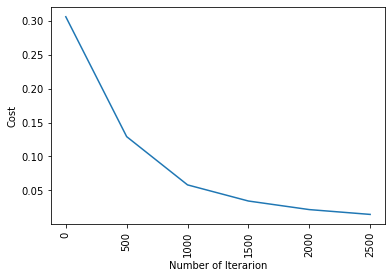

train accuracy: 99.71264367816092 %
test accuracy: 91.93548387096774 %


In [14]:
# 2 - Layer neural network
def two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations):
    cost_list = []
    index_list = []
    #initialize parameters and layer sizes
    parameters = initialize_parameters_and_layer_sizes_NN(x_train, y_train)

    for i in range(0, num_iterations):
         # forward propagation
        A2, cache = forward_propagation_NN(x_train,parameters)
        # compute cost
        cost = compute_cost_NN(A2, y_train, parameters)
         # backward propagation
        grads = backward_propagation_NN(parameters, cache, x_train, y_train)
         # update parameters
        parameters = update_parameters_NN(parameters, grads)
        
        if i % 500 == 0:
            cost_list.append(cost)
            index_list.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    plt.plot(index_list,cost_list)
    plt.xticks(index_list,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    
    # predict
    y_prediction_test = predict_NN(parameters,x_test)
    y_prediction_train = predict_NN(parameters,x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))
    return parameters

parameters = two_layer_neural_network(x_train, y_train,x_test,y_test, num_iterations=2501)